In [1]:
from LABNET import Neuron, Net, Lab

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt


In [3]:
dl_big = [
    ['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i'] #0-7 for inputs
    
    ,['fc',[0,1,2]]
    ,['fc',[-2,3,-4]]
    ,['fc',[3,4,5]]
    ,['fc',[3,5,7]]
    ,['fc',[0,7]] #8 - 12 for this layer
    
    ,['fc',[8,10]]
    ,['fc',[9,-11]]
    ,['fc',[12]]
    ,['fc',[-8,-9]] #13 - 16
    
    
    
    ,['o',[-13,14]]
    ,['o',[-14,15,-16]]
    ,['o',[-15,-16]]
    ,['o',[-13,16]]
    
]

In [4]:
nn_big = Net(dl_big)
nn_big.generate_inputs()
nn_big.generate_outputs()
nn_big.tensorize()

self.inputs and self.outputs are now tensors of shape torch.Size([256, 8]) and torch.Size([256, 4]) respectively!


In [5]:
nn_big.outputs

tensor([[False,  True, False, False],
        [False, False,  True, False],
        [False,  True, False, False],
        ...,
        [False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True]])

In [ ]:
nn_big.percent_true()

In [ ]:
nn_big.input_size

In [19]:
def create_neural_network(layer_sizes):
    # Extract the number of inputs and outputs from the layer_sizes list
    num_inputs = layer_sizes[0]
    num_outputs = layer_sizes[-1]
    
    # Create a sequential model
    model = nn.Sequential()
    
    # Add input layer
    model.add_module("input_layer", nn.Linear(num_inputs, layer_sizes[1]))
    model.add_module("input_layer_activation", nn.ReLU())
    
    # Add hidden layers
    for i in range(2, len(layer_sizes)-1):
        model.add_module(f"hidden_layer_{i}", nn.Linear(layer_sizes[i-1], layer_sizes[i]))
        model.add_module(f"hidden_layer_{i}_activation", nn.ReLU())
    
    # Add output layer
    model.add_module("output_layer", nn.Linear(layer_sizes[-2], num_outputs))
    #model.add_module("output_layer_activation", nn.ReLU())
    #model = model.to(dtype=torch.float)
    return model

def initialize_weights_uniform(neural_network, low=-10, high=10):
    for module in neural_network.modules():
        if isinstance(module, nn.Linear):
            init.uniform_(module.weight, low, high)
            if module.bias is not None:
                init.uniform_(module.bias, low, high)

import torch
from torch.distributions import uniform, normal

def generate_random_data(nn,n, dist_type = 'normal', low =0, high=1):
    
    input_size = nn.input_layer.in_features ##this only works with create_neural_network func above
    low = torch.tensor(low,dtype=torch.float32).expand(input_size)
    high = torch.tensor(high,dtype=torch.float32).expand(input_size)
    
    
    if dist_type == 'uniform':
        dist = uniform.Uniform(low, high)
    elif dist_type == 'normal':
        dist = normal.Normal(low, high) 
    
    samples = dist.sample((n,))
    
    outputs = nn(samples)
    
    return samples,outputs

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

In [53]:
import torch.nn.init as init

n = 1000 #number of samples to generate
layer_sizes = [7, 20, 20, 10]  # Inputs: 4, Hidden layers: [8, 8], Outputs: 3
neural_network = create_neural_network(layer_sizes)
initialize_weights_uniform(neural_network,0,1)

inputs, outputs = generate_random_data(neural_network,n,'uniform',-10,10)

inputs.shape,outputs.shape

(torch.Size([1000, 7]), torch.Size([1000, 10]))

In [54]:
inputs,outputs

(tensor([[-6.7347,  5.2124, -2.1061,  ..., -9.0121,  1.4282, -0.0900],
         [ 5.1785,  2.6858, -9.2745,  ..., -2.3733, -7.0407, -0.0921],
         [ 7.7462,  0.4597,  2.2673,  ...,  6.0695, -7.5233, -0.5756],
         ...,
         [-5.1099,  6.2657, -4.3260,  ...,  5.2882,  8.8169,  7.2690],
         [ 0.2673,  4.2207,  4.3431,  ...,  6.7522, -9.2167,  3.4641],
         [ 3.9436,  6.5536,  9.6787,  ..., -5.9416, -5.9540,  6.1499]]),
 tensor([[   6.8223,    7.0249,    7.3090,  ...,    5.6740,    5.6279,
             5.7510],
         [   6.8223,    7.0249,    7.3090,  ...,    5.6740,    5.6279,
             5.7510],
         [ 448.3922,  533.2187,  480.3141,  ...,  439.9229,  481.6610,
           429.1965],
         ...,
         [1273.2421, 1467.2266, 1342.4529,  ..., 1254.9010, 1276.4611,
          1197.1962],
         [ 810.2016,  944.5040,  861.1984,  ...,  794.2094,  832.5211,
           765.5400],
         [1065.9453, 1261.5269, 1143.8605,  ..., 1056.7197, 1111.5150,
        

In [55]:
# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = nn.Linear(7, 7) ##make these all variables duh
        self.hidden_2 = nn.Linear(7,7)
        self.output = nn.Linear(7, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden_1(x))
        x = self.relu(self.hidden_2(x))
        x = self.output(x)
        return x

In [71]:
model = MyModel()


In [64]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [65]:
input_data = inputs
output_data = outputs

In [66]:
input_data

tensor([[ 4.9361e+00, -9.1739e+00,  5.8011e+00, -5.4264e-03, -2.6733e+00,
          4.4707e+00,  8.4909e+00]])

In [69]:
# Training loop
samples = n

num_epochs = 10

lab = Lab(model,num_epochs,samples)
data = list(zip(input_data, output_data))

for epoch in range(num_epochs):
    
    sample = 0
    
    random.shuffle(data)
    shuffled_inputs, shuffled_outputs = zip(*data)
    
    for inputs, targets in zip(shuffled_inputs, shuffled_outputs):
        inputs = inputs.unsqueeze(0)  
        targets = targets.unsqueeze(0)
    
        output = model(inputs)
    
        loss = criterion(output, targets)

    
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        
        optimizer.step()
        lab.record(model,epoch,samples,sample)
        #print or store loss if you wanna
        #loss.item()

        
        sample += 1
 


In [70]:
lab.LabParams['hidden_1.weight']

tensor([[[-27.1816,  52.2659, -32.3684,  ...,  16.0235, -24.7652, -47.6180],
         [-24.4977,  46.9352, -28.3834,  ...,  14.3505, -21.5028, -41.9923],
         [-13.3302,  26.1592, -15.2522,  ...,   7.9225, -11.7011, -23.6564],
         ...,
         [-24.7558,  47.5744, -29.9963,  ...,  14.3839, -22.7181, -43.5864],
         [-23.8836,  45.8909, -27.7176,  ...,  14.0695, -21.7098, -41.0639],
         [-26.0273,  50.1643, -30.7436,  ...,  15.3332, -24.0575, -45.2219]],

        [[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,  ...

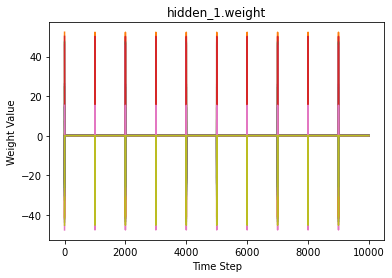

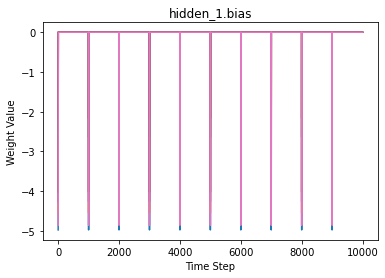

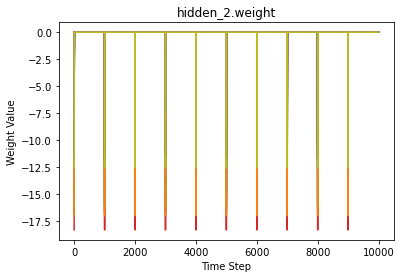

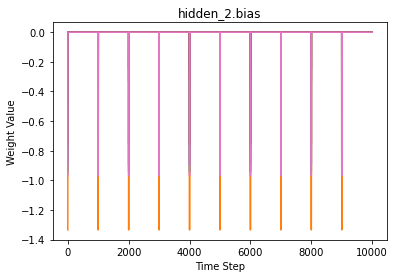

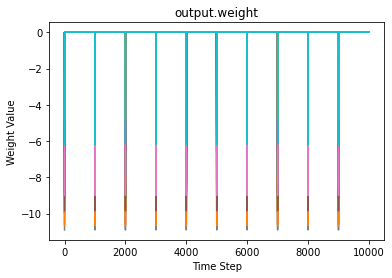

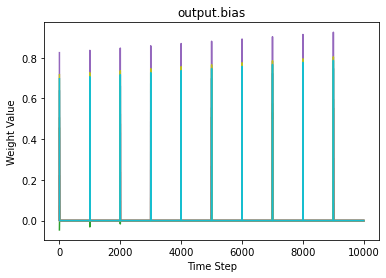

In [74]:
lab.graph(diff=0)